<a href="https://colab.research.google.com/github/Minorito/CatBoost_MusicRecognition/blob/main/CatBoostClassifier_Est%C3%A1gioPesquisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install catboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint, mode
import tensorflow as tf
import tensorflow.python.keras as k
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import minmax_scale, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
import librosa, IPython
from IPython.display import display
import librosa.display
from tqdm import tqdm
import random
from sklearn.model_selection import KFold

In [ ]:
seed = 42
random.seed = seed
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/My Drive/musicas/datasets/Data/features_3_sec.csv')
print("Dataset has", data.shape)
data.head()
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

Dataset has (9990, 60)


In [ ]:
label_encoder = LabelEncoder()
labels = data['label']
label_encoder.fit(labels)
data.insert(60, 'label_id', 9999)
data.insert(1, 'filename_full', '')
for i in range(len(data)):
    label = data.loc[i,'label']
    label_id =label_encoder.transform([label])
    data.loc[i,'label_id']=label_id.item()
    data.loc[i,'filename_full']=str(data.loc[i,'filename']).split('.')[0]+"."+str(data.loc[i,'filename']).split('.')[1]+"."+str(data.loc[i,'filename']).split('.')[3]
data['label_id']=data['label_id'].astype(int)

In [ ]:
X_full = data.drop(['filename','filename_full', 'length','label', 'label_id'], axis = 1)
y_full = data['label_id'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state = seed, shuffle = True)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
acc_per_fold = []
loss_per_fold = []
num_folds = 10
fold_no = 1

In [ ]:
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [ ]:
kfold = KFold(n_splits=num_folds, shuffle=True)

In [ ]:
for train, test in kfold.split(inputs, targets):
    model = CatBoostClassifier(random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    model.fit(inputs[train],targets[train])
    
    acc_per_fold.append(model.score(inputs[test], targets[test]) * 100)
    loss_per_fold.append(model.score(inputs[test], targets[test]))

    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...
------------------------------------------------------------------------
Training for fold 6 ...
------------------------------------------------------------------------
Training for fold 7 ...
------------------------------------------------------------------------
Training for fold 8 ...
------------------------------------------------------------------------
Training for fold 9 ...
------------------------------------------------------------------------
Training for fold 10 ...


In [ ]:
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')    

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.908908908908909 - Accuracy: 90.8908908908909%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.923923923923924 - Accuracy: 92.3923923923924%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9099099099099099 - Accuracy: 90.990990990991%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.9099099099099099 - Accuracy: 90.990990990991%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.9309309309309309 - Accuracy: 93.09309309309309%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.9169169169169169 - Accuracy: 91.69169169169169%
------------------------------------------------------------------------
> Fold 

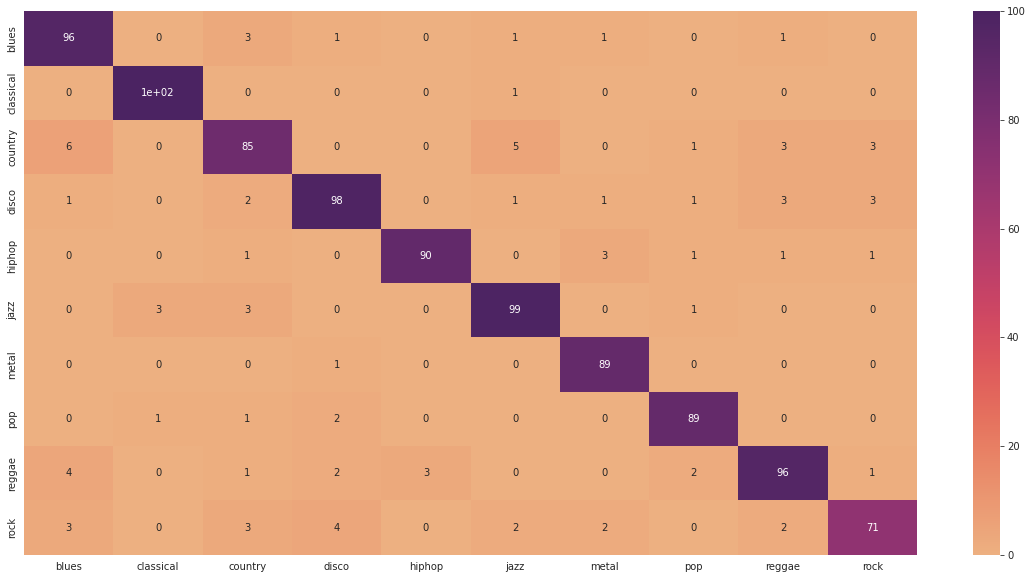

In [ ]:
y_pred_test = model.predict(inputs[test])
cm = confusion_matrix(targets[test], y_pred_test)
plt.figure(figsize = (20, 10))
sns.heatmap(cm, cmap="flare", annot=True, xticklabels = genres, yticklabels= genres);
plt.show()

In [ ]:
matriz_total= np.sum(cm)
print(f'Soma de todos elementos da matriz {matriz_total}')

n = 10

diagonal_principal = sum(cm[i][i] for i in range(n))
print(f'Soma diagonal principal {diagonal_principal}')

print(f'Matriz Confusão: {(diagonal_principal/matriz_total)*100}%')

Soma de todos elementos da matriz 999
Soma diagonal principal 913
Matriz Confusão: 91.3913913913914%


In [ ]:
print(classification_report(targets[test], y_pred_test, digits=3, target_names=genres))

              precision    recall  f1-score   support

       blues      0.873     0.932     0.901       103
   classical      0.962     0.990     0.976       101
     country      0.859     0.825     0.842       103
       disco      0.907     0.891     0.899       110
      hiphop      0.968     0.928     0.947        97
        jazz      0.908     0.934     0.921       106
       metal      0.927     0.989     0.957        90
         pop      0.937     0.957     0.947        93
      reggae      0.906     0.881     0.893       109
        rock      0.899     0.816     0.855        87

    accuracy                          0.914       999
   macro avg      0.914     0.914     0.914       999
weighted avg      0.914     0.914     0.913       999

